In [1]:
base_path = "/content/drive/My Drive/Github/mtc-device-activation"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')# Load saved data

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [4]:
!apt-get update
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,923 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.9 kB]
Get:13 https://ppa.la

In [5]:
import numpy as np

# === Base Path ===
base_path = "/content/drive/MyDrive/Github/mtc-device-activation"

# === Load general simulation data ===
data = np.load(f"{base_path}/communication_model/data/communication_simulation_general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

# === Load ground truth ===
all_gamma = np.load(f"{base_path}/communication_model/data/communication_simulation_gamma.npz", allow_pickle=True)["all_gamma"]
all_z = np.load(f"{base_path}/communication_model/data/communication_simulation_z.npz", allow_pickle=True)["all_z"]

def load_estimates(folder_name, file_prefix, num_sets=5):
    """Loads and concatenates estimation results from multiple .npz files."""
    file_paths = [
        f"{base_path}/estimation/{folder_name}/data/{file_prefix}_set_{i}.npz"
        for i in range(1, num_sets + 1)
    ]
    all_z_est, all_gamma_est = [], []
    for path in file_paths:
        est = np.load(path, allow_pickle=True)
        all_z_est.append(est["z_result_all"])
        all_gamma_est.append(est["gamma_result_all"])
    return (
        np.concatenate(all_z_est, axis=0),     # (num_samples, num_devices, num_antennas)
        np.concatenate(all_gamma_est, axis=0)  # (num_samples, num_devices)
    )

# === Load for SNR=12, all pilot lengths ===
folder_1 = "snr_db_12_pilot_length_all"
prefix_1 = "sbl_snr_db_12_pilot_length_all"
z_est_case1, gamma_est_case1 = load_estimates(folder_1, prefix_1)

# === Load for all SNRs, pilot length=30 ===
folder_2 = "snr_db_all_pilot_length_30"
prefix_2 = "sbl_snr_db_all_pilot_length_30"
z_est_case2, gamma_est_case2 = load_estimates(folder_2, prefix_2)

# === Confirm shapes ===
print("CASE 1 - SNR=12, all pilot lengths")
print("  Ground truth z:", all_z.shape, "Estimates:", z_est_case1.shape)
print("  Ground truth gamma:", all_gamma.shape, "Estimates:", gamma_est_case1.shape)

print("\nCASE 2 - All SNRs, pilot length=30")
print("  Ground truth z:", all_z.shape, "Estimates:", z_est_case2.shape)
print("  Ground truth gamma:", all_gamma.shape, "Estimates:", gamma_est_case2.shape)


CASE 1 - SNR=12, all pilot lengths
  Ground truth z: (1000, 400, 4) Estimates: (1000, 6)
  Ground truth gamma: (1000, 400) Estimates: (1000, 6)

CASE 2 - All SNRs, pilot length=30
  Ground truth z: (1000, 400, 4) Estimates: (1000, 6)
  Ground truth gamma: (1000, 400) Estimates: (1000, 6)


In [6]:
def plot_metrics(all_gamma_est, all_z_est, x_array, x_label):
    import numpy as np
    import matplotlib.pyplot as plt

    threshold_array = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4]
    num_samples = all_gamma.shape[0]
    num_x = len(x_array)

    f1_plot_data = np.zeros((len(threshold_array), num_x))
    nmse_plot_data = np.zeros((len(threshold_array), num_x))
    hr_plot_data = np.zeros((len(threshold_array), num_x))
    far_plot_data = np.zeros((len(threshold_array), num_x))

    for t_idx, threshold in enumerate(threshold_array):
        for x_idx in range(num_x):

            f1_list = []
            nmse_list = []
            hr_list = []
            far_list = []

            for sample_index in range(num_samples):
                gamma_true = all_gamma[sample_index]
                z_true = all_z[sample_index]

                gamma_est = all_gamma_est[sample_index, x_idx]
                z_est = all_z_est[sample_index, x_idx]

                gamma_est_bool = gamma_est > threshold

                # --- F1 ---
                TP = np.sum((gamma_est_bool == 1) & (gamma_true == 1))
                FP = np.sum((gamma_est_bool == 1) & (gamma_true == 0))
                FN = np.sum((gamma_est_bool == 0) & (gamma_true == 1))
                precision = TP / (TP + FP) if (TP + FP) > 0 else 0
                recall = TP / (TP + FN) if (TP + FN) > 0 else 0
                f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

                # --- NMSE ---
                nmse = (np.linalg.norm(z_true[gamma_true == 1] - z_est[gamma_true == 1]) ** 2 /
                        np.linalg.norm(z_true[gamma_true == 1]) ** 2) if np.any(gamma_true == 1) else 0

                # --- Hit Rate ---
                active_devices = np.sum(gamma_true == 1)
                hr = (100 * np.sum((gamma_est_bool == 1) & (gamma_true == 1)) / active_devices
                      if active_devices > 0 else 0)

                # --- False Alarm Rate ---
                inactive_devices = np.sum(gamma_true == 0)
                far = (100 * np.sum((gamma_est_bool == 1) & (gamma_true == 0)) / inactive_devices
                       if inactive_devices > 0 else 0)

                f1_list.append(f1)
                nmse_list.append(nmse)
                hr_list.append(hr)
                far_list.append(far)

            f1_plot_data[t_idx, x_idx] = np.mean(f1_list)
            nmse_plot_data[t_idx, x_idx] = np.mean(nmse_list)
            hr_plot_data[t_idx, x_idx] = np.mean(hr_list)
            far_plot_data[t_idx, x_idx] = np.mean(far_list)

    # Set global plot parameters
    plt.rcParams.update({
        'font.family': 'serif',
        'text.usetex': True,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'grid.linestyle': '--',
        'grid.alpha': 0.7,
    })


    # --- Plot F1 ---
    plt.figure()
    for t_idx, threshold in enumerate(threshold_array):
        plt.plot(x_array, f1_plot_data[t_idx], marker='o', label=f"Thr={threshold}")
    plt.xlabel(x_label)
    plt.ylabel("F1 Score")
    plt.title(f"{x_label} vs F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot NMSE ---
    plt.figure()
    for t_idx, threshold in enumerate(threshold_array):
        plt.plot(x_array, nmse_plot_data[t_idx], marker='o', label=f"Thr={threshold}")
    plt.xlabel(x_label)
    plt.ylabel("NMSE")
    plt.title(f"{x_label} vs NMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot Hit Rate ---
    plt.figure()
    for t_idx, threshold in enumerate(threshold_array):
        plt.plot(x_array, hr_plot_data[t_idx], marker='o', label=f"Thr={threshold}")
    plt.xlabel(x_label)
    plt.ylabel("Hit Rate (%)")
    plt.title(f"{x_label} vs Hit Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot False Alarm Rate ---
    plt.figure()
    for t_idx, threshold in enumerate(threshold_array):
        plt.plot(x_array, far_plot_data[t_idx], marker='o', label=f"Thr={threshold}")
    plt.xlabel(x_label)
    plt.ylabel("False Alarm Rate (%)")
    plt.title(f"{x_label} vs False Alarm Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


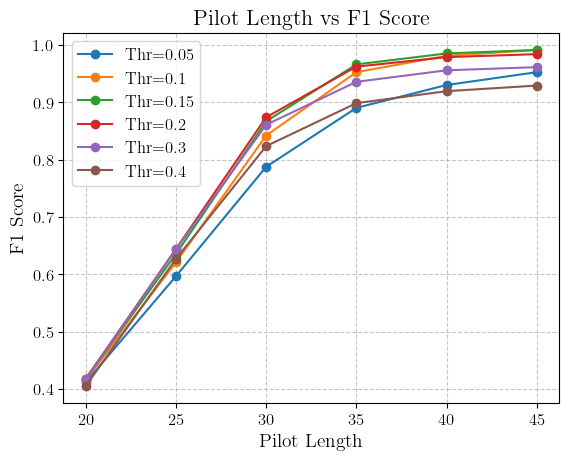

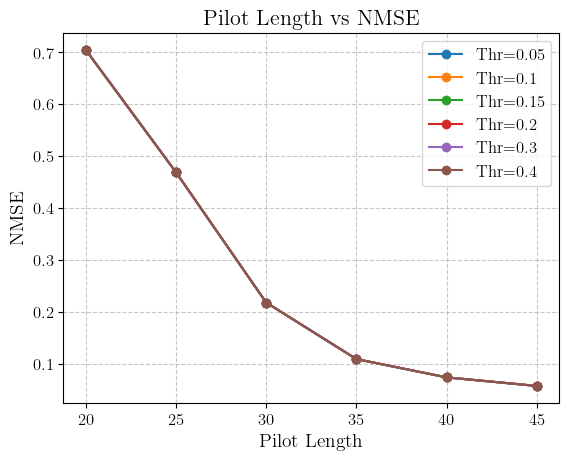

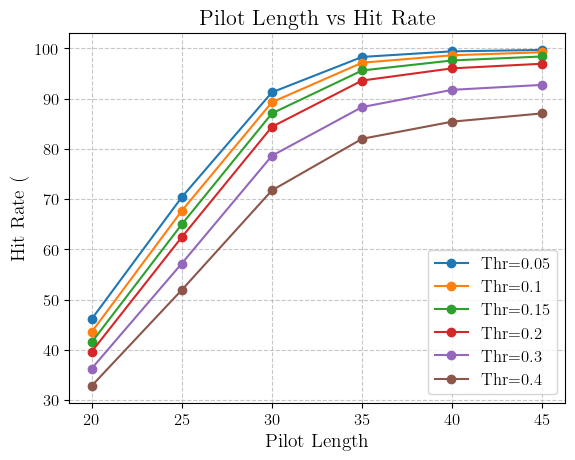

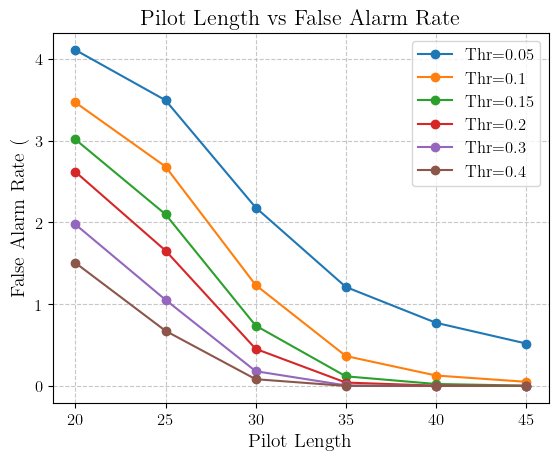

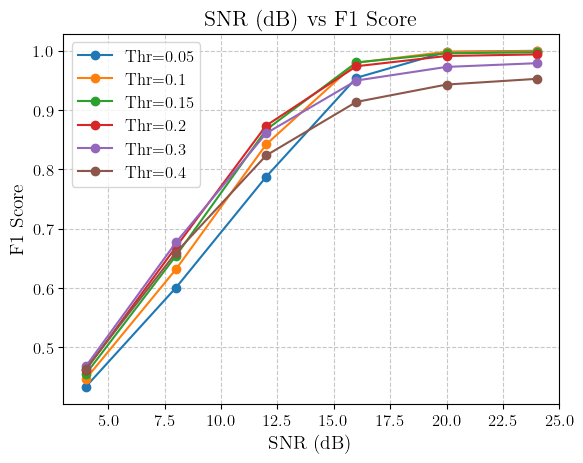

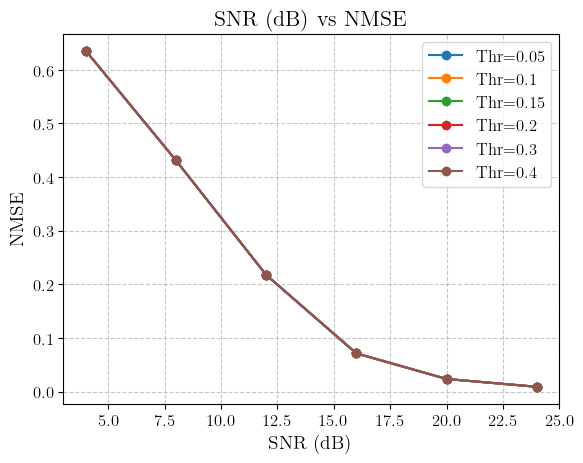

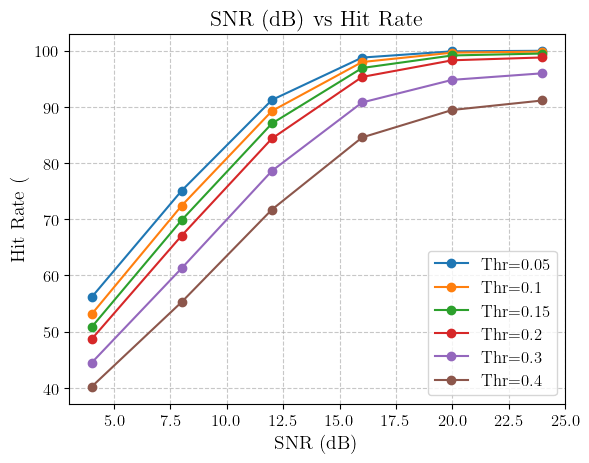

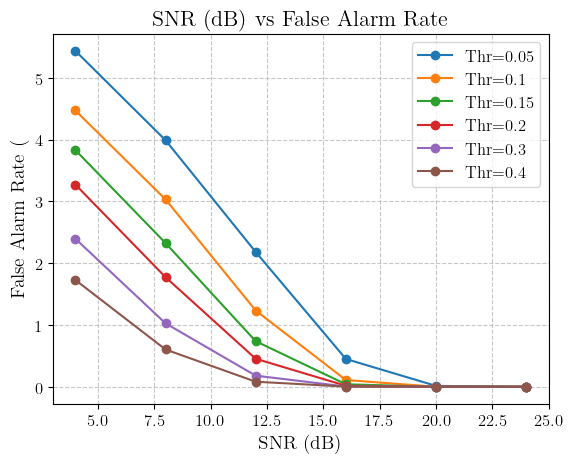

In [7]:
# Case 1: fixed SNR, varying pilot length
plot_metrics(gamma_est_case1, z_est_case1, pilot_length_array, "Pilot Length")

# Case 2: fixed pilot length, varying SNR
plot_metrics(gamma_est_case2, z_est_case2, snr_db_array, "SNR (dB)")
